# 0. Import Dependencies

In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
import tensorflow as tf
import math

from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score, classification_report
from tensorflow.keras.utils import to_categorical

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from tensorflow.keras.models import Sequential, Model

from tensorflow.keras.layers import (LSTM, Dense, Concatenate, Attention, Dropout, Softmax,
                                     Input, Flatten, Activation, Bidirectional, Permute, multiply, 
                                     ConvLSTM2D, MaxPooling3D, TimeDistributed, Conv2D, MaxPooling2D)

from scipy import stats

# disable some of the tf/keras training warnings 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = "3"
tf.get_logger().setLevel("ERROR")
tf.autograph.set_verbosity(1)

# suppress untraced functions warning
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

2024-03-02 05:36:42.076637: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-02 05:36:42.076707: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-02 05:36:42.076747: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-02 05:36:42.084397: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# 1. Keypoints using MP Pose

In [2]:
# Pre-trained pose estimation model from Google Mediapipe
mp_pose = mp.solutions.pose

# Supported Mediapipe visualization tools
mp_drawing = mp.solutions.drawing_utils

In [3]:
def mediapipe_detection(image, model):
    """
    This function detects human pose estimation keypoints from webcam footage
    
    """
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [4]:
def draw_landmarks(image, results):
    """
    This function draws keypoints and landmarks detected by the human pose estimation model
    
    """
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2), 
                                mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2) 
                                 )

In [5]:
FPS = 30 # webcam video fram rate 

# 2. Extract Keypoints

In [6]:
def extract_keypoints(results):
    """
    Processes and organizes the keypoints detected from the pose estimation model 
    to be used as inputs for the exercise decoder models
    
    """
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    return pose

# 3. Setup Folders for Collection

In [7]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join(os. getcwd(),'../Data_Round1/Data_R1') 
print(DATA_PATH)

# make directory if it does not exist yet
# if not os.path.exists(DATA_PATH):
#     os.makedirs(DATA_PATH)

# Actions/exercises that we try to detect
actions = np.array(['chest fly machine', 'deadlift', 'hammer curl',
                    'incline bench press', 'pull Up', 'tricep dips', 
                    'decline bench press', 'leg raises', 'shoulder press',
                    'plank', 'leg extension', 'tricep Pushdown',
                    'bench press', 'lateral raise', 'squat',
                    'push-up', 'barbell biceps curl', 'russian twist',
                    'romanian deadlift', 'hip thrust', 'lat pulldown',
                    't bar row'
                    ])
num_classes = len(actions)

# How many videos worth of data
no_sequences = 50

# Videos are going to be this many frames in length
sequence_length = 60

# Folder start
# Change this to collect more data and not lose previously collected data
start_folder = 0

/media/volcano/SPSSD/DATA1/DUT/AI4LIFE/Exercise_Recognition_AI/../Data_Round1/Data_R1


# 4. Collect Keypoint Values for Training and Testing

In [8]:
import json

In [9]:
data_poses = {}
min_d = 1000
for action in actions:
    data_poses[action] = {}
    for filename in os.listdir(DATA_PATH+"/"+action+"/pose"):
        if filename.endswith('.json'):
            file_path = os.path.join(DATA_PATH+"/"+action+"/pose", filename)
            key_file = filename.replace('.json', '').replace('results_', '')
            # Open the JSON file and load its contents
            with open(file_path, 'r') as json_file:
                data = json.load(json_file)
            if len(data['instance_info']) >= sequence_length:
                # Do something with the data (for example, print it)
                data_poses[action][key_file] = []
                for frame in range(len(data['instance_info'])):
                    data_poses[action][key_file].append(data['instance_info'][frame]['instances'][0]['keypoints'])
                # if min_d > len(data['instance_info']):
                #     min_d = len(data['instance_info'])
                #     print(len(data['instance_info']))

In [10]:
len(data_poses[actions[2]]['hammer curl_2'])

381

In [11]:
list(data_poses[actions[2]].keys())

['hammer curl_3',
 'hammer curl_10',
 'hammer curl_6',
 'hammer curl_8',
 'hammer curl_11',
 'hammer curl_1',
 'hammer curl_18',
 'hammer curl_13',
 'hammer curl_17',
 'hammer curl_12',
 'hammer curl_16',
 'hammer curl_9',
 'hammer curl_19',
 'hammer curl_15',
 'hammer curl_2',
 'hammer curl_5',
 'hammer curl_4',
 'hammer curl_7']

# 5. Preprocess Data and Create Labels/Features

In [12]:
label_map = {label:num for num, label in enumerate(actions)}

In [13]:
label_map

{'chest fly machine': 0,
 'deadlift': 1,
 'hammer curl': 2,
 'incline bench press': 3,
 'pull Up': 4,
 'tricep dips': 5,
 'decline bench press': 6,
 'leg raises': 7,
 'shoulder press': 8,
 'plank': 9,
 'leg extension': 10,
 'tricep Pushdown': 11,
 'bench press': 12,
 'lateral raise': 13,
 'squat': 14,
 'push-up': 15,
 'barbell biceps curl': 16,
 'russian twist': 17,
 'romanian deadlift': 18,
 'hip thrust': 19,
 'lat pulldown': 20,
 't bar row': 21}

In [14]:
np.load('/media/volcano/SPSSD/DATA1/DUT/AI4LIFE/Exercise_Recognition_AI/data/'+actions[0]+'/1/2.npy').shape

(132,)

In [15]:
# Load and organize recorded training data
sequences, labels = [], []
for action in actions:
    for sequence in list(data_poses[action].keys()):
        mod_d = len(data_poses[action][sequence])//sequence_length
        for m in range(mod_d):
            window = []
            for frame_num in range(m*sequence_length, (m+1)*sequence_length):         
                # LSTM input data
                res = np.asarray(data_poses[action][sequence][frame_num]).flatten()
                window.append(res)  
                
            sequences.append(window)
            labels.append(label_map[action])

In [16]:
# Make sure first dimensions of arrays match
X = np.array(sequences)
y = to_categorical(labels).astype(int)
print(X.shape, y.shape)

(2130, 60, 51) (2130, 22)


In [17]:
# Split into training, validation, and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=1)
print(X_train.shape, y_train.shape)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=15/90, random_state=2)

(1917, 60, 51) (1917, 22)


# 6. Build and Train Neural Networks

In [18]:
# Callbacks to be used during neural network training 
es_callback = EarlyStopping(monitor='val_loss', min_delta=5e-4, patience=10, verbose=0, mode='min')
lr_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001, verbose=0, mode='min')
chkpt_callback = ModelCheckpoint(filepath=DATA_PATH, monitor='val_loss', verbose=0, save_best_only=True, 
                                 save_weights_only=False, mode='min', save_freq=1)

# Optimizer
# opt = tf.keras.optimizers.Adam(learning_rate=0.01)
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.01)

# some hyperparamters
batch_size = 32
max_epochs = 500

## 6a. LSTM

In [19]:
# Set up Tensorboard logging and callbacks
NAME = f"ExerciseRecognition-LSTM-{int(time.time())}"
log_dir = os.path.join(os.getcwd(), 'logs', NAME,'')
tb_callback = TensorBoard(log_dir=log_dir)

callbacks = [tb_callback, es_callback, lr_callback, chkpt_callback]

In [20]:
lstm = Sequential()
lstm.add(LSTM(128, return_sequences=True, activation='relu', input_shape=(sequence_length, 51)))
lstm.add(LSTM(256, return_sequences=True, activation='relu'))
lstm.add(LSTM(128, return_sequences=False, activation='relu'))
lstm.add(Dense(128, activation='relu'))
lstm.add(Dense(64, activation='relu'))
lstm.add(Dense(actions.shape[0], activation='softmax'))
print(lstm.summary())

2024-03-02 05:37:02.525092: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-02 05:37:02.533926: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-02 05:37:02.534115: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 128)           92160     
                                                                 
 lstm_1 (LSTM)               (None, 60, 256)           394240    
                                                                 
 lstm_2 (LSTM)               (None, 128)               197120    
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 22)                1430      
                                                                 
Total params: 709718 (2.71 MB)
Trainable params: 709718 

In [21]:
# lstm.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
# lstm.fit(X_train, y_train, batch_size=batch_size, epochs=max_epochs, validation_data=(X_val, y_val), callbacks=callbacks)

## 6b. LSTM + Attention

In [22]:
# Set up Tensorboard logging and callbacks
NAME = f"ExerciseRecognition-AttnLSTM-{int(time.time())}"
log_dir = os.path.join(os.getcwd(), 'logs', NAME,'')
tb_callback = TensorBoard(log_dir=log_dir)

callbacks = [tb_callback, es_callback, lr_callback, chkpt_callback]

In [23]:
def attention_block(inputs, time_steps):
    """
    Attention layer for deep neural network
    
    """
    # Attention weights
    a = Permute((2, 1))(inputs)
    a = Dense(time_steps, activation='softmax')(a)
    
    # Attention vector
    a_probs = Permute((2, 1), name='attention_vec')(a)
    
    # Luong's multiplicative score
    output_attention_mul = multiply([inputs, a_probs], name='attention_mul') 
    
    return output_attention_mul

In [24]:
HIDDEN_UNITS = 256

# Input
inputs = Input(shape=(sequence_length, 51))

# Bi-LSTM
lstm_out = Bidirectional(LSTM(HIDDEN_UNITS, return_sequences=True))(inputs)

# Attention
attention_mul = attention_block(lstm_out, sequence_length)
attention_mul = Flatten()(attention_mul)

# Fully Connected Layer
x = Dense(2*HIDDEN_UNITS, activation='relu')(attention_mul)
x = Dropout(0.5)(x)

# Output
x = Dense(actions.shape[0], activation='softmax')(x)

# Bring it all together
AttnLSTM = Model(inputs=[inputs], outputs=x)
print(AttnLSTM.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 60, 51)]             0         []                            
                                                                                                  
 bidirectional (Bidirection  (None, 60, 512)              630784    ['input_1[0][0]']             
 al)                                                                                              
                                                                                                  
 permute (Permute)           (None, 512, 60)              0         ['bidirectional[0][0]']       
                                                                                                  
 dense_3 (Dense)             (None, 512, 60)              3660      ['permute[0][0]']         

In [25]:
AttnLSTM.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
AttnLSTM.fit(X_train, y_train, batch_size=batch_size, epochs=max_epochs, validation_data=(X_val, y_val), callbacks=callbacks)

Epoch 1/500


2024-03-02 05:37:08.034667: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700


50/50 [==============================] - 8s 35ms/step - loss: 2.1956 - categorical_accuracy: 0.3262 - val_loss: 1.4024 - val_categorical_accuracy: 0.5344 - lr: 0.0100
Epoch 2/500
50/50 [==============================] - 1s 13ms/step - loss: 1.4051 - categorical_accuracy: 0.5385 - val_loss: 1.1429 - val_categorical_accuracy: 0.6531 - lr: 0.0100
Epoch 3/500
50/50 [==============================] - 1s 13ms/step - loss: 1.2076 - categorical_accuracy: 0.5999 - val_loss: 1.0932 - val_categorical_accuracy: 0.6438 - lr: 0.0100
Epoch 4/500
50/50 [==============================] - 1s 12ms/step - loss: 0.9819 - categorical_accuracy: 0.6706 - val_loss: 0.8974 - val_categorical_accuracy: 0.7594 - lr: 0.0100
Epoch 5/500
50/50 [==============================] - 1s 13ms/step - loss: 0.9036 - categorical_accuracy: 0.6957 - val_loss: 0.6988 - val_categorical_accuracy: 0.7906 - lr: 0.0100
Epoch 6/500
50/50 [==============================] - 1s 13ms/step - loss: 0.7129 - categorical_accuracy: 0.7771 - val

In [37]:
# Model map
models = {
    # 'LSTM': lstm, 
    'LSTM_Attention_128HUs': AttnLSTM, 
}

# 7a. Save Weights

In [38]:
for model_name, model in models.items():
    save_dir = os.path.join(os.getcwd(), f"{model_name}_f1.h5")
    model.save(save_dir)

/home/volcano/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# 7b. Load Weights

In [28]:
# Run model rebuild before doing this
for model_name, model in models.items():
    load_dir = os.path.join(os.getcwd(), f"{model_name}_f1.h5")
    model.load_weights(load_dir)

# 8. Make Predictions

In [29]:
for model in models.values():
    res = model.predict(X_test, verbose=0)   

# 9. Evaluations using Confusion Matrix and Accuracy

In [30]:
eval_results = {}
eval_results['confusion matrix'] = None
eval_results['accuracy'] = None
eval_results['precision'] = None
eval_results['recall'] = None
eval_results['f1 score'] = None

confusion_matrices = {}
classification_accuracies = {}   
precisions = {}
recalls = {}
f1_scores = {} 

## 9a. Confusion Matrices

In [31]:
for model_name, model in models.items():
    yhat = model.predict(X_test, verbose=0)
    # Get list of classification predictions
    ytrue = np.argmax(y_test, axis=1).tolist()
    yhat = np.argmax(yhat, axis=1).tolist()
    
    # Confusion matrix
    confusion_matrices[model_name] = multilabel_confusion_matrix(ytrue, yhat)
    # print(f"{model_name} confusion matrix: {os.linesep}{confusion_matrices[model_name]}")

# Collect results 
eval_results['confusion matrix'] = confusion_matrices

In [32]:
corr_matrix_k = np.zeros((len(actions), len(actions)))
corr_matrix = np.zeros((len(actions), len(actions)))
for t in range(len(yhat)):
    corr_matrix_k[ytrue[t]][yhat[t]] += 1
for t in range(len(actions)):
    for k in range(len(actions)):
        corr_matrix[t][k] = corr_matrix_k[t][k]/np.sum(corr_matrix_k[t])

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'PIXEL SPACE Correlation graph')

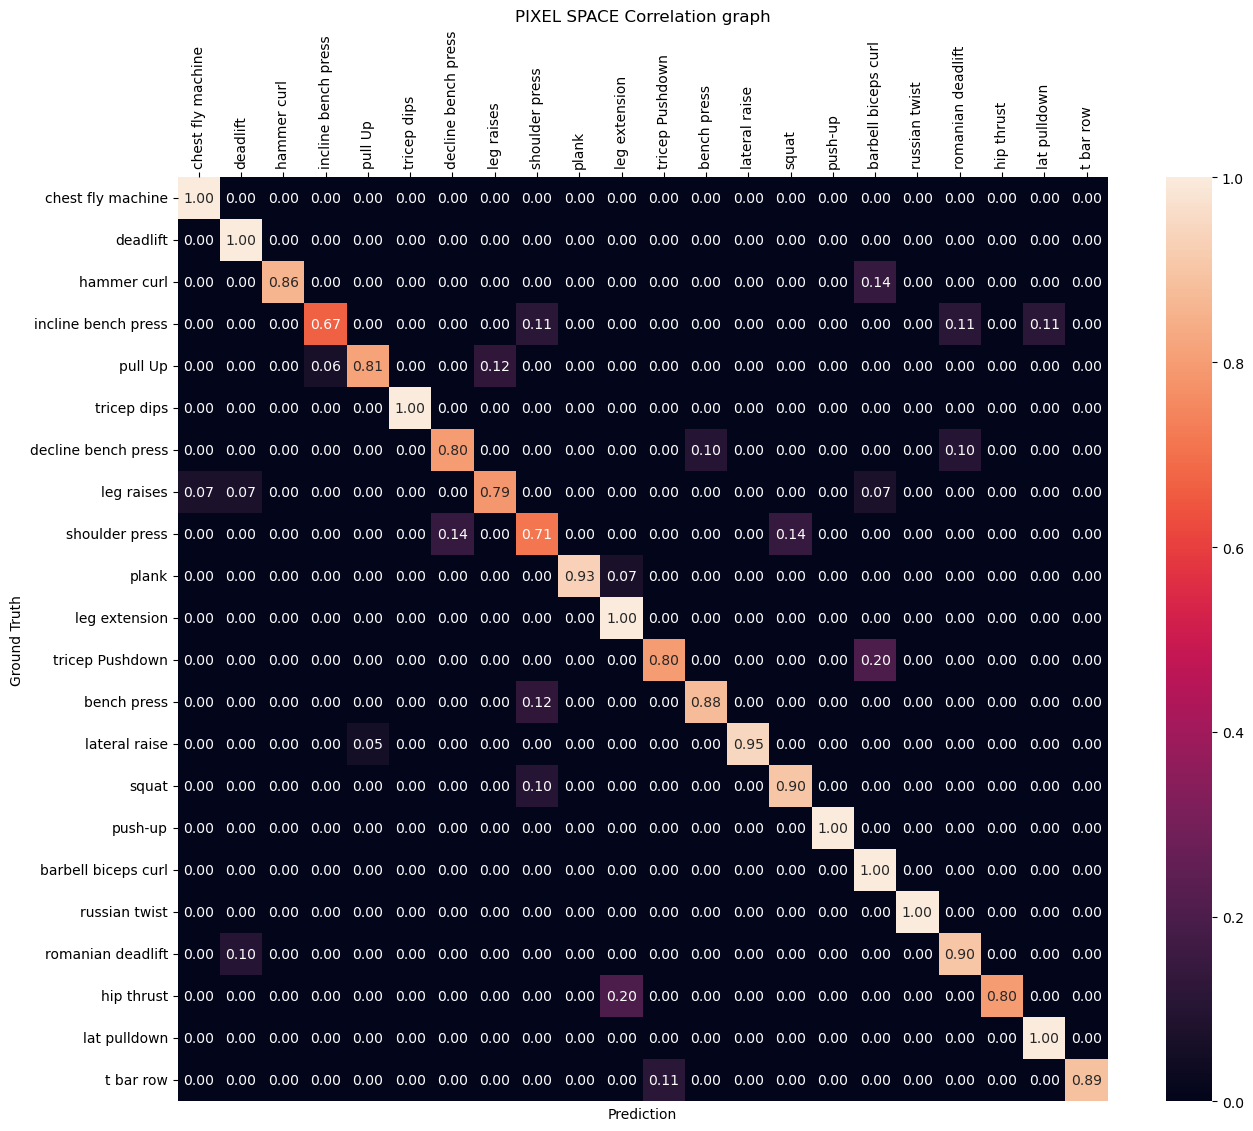

In [34]:
plt.figure(figsize=(15, 12))
ax = sns.heatmap(corr_matrix, annot=True, fmt=".2f",
            xticklabels=actions, yticklabels=actions)
ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)
plt.xticks(rotation=90)
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('PIXEL SPACE Correlation graph')

## 9b. Accuracy

In [35]:
for model_name, model in models.items():
    yhat = model.predict(X_test, verbose=0)
    
    # Get list of classification predictions
    ytrue = np.argmax(y_test, axis=1).tolist()
    yhat = np.argmax(yhat, axis=1).tolist()
    
    # Model accuracy
    classification_accuracies[model_name] = accuracy_score(ytrue, yhat)    
    print(f"{model_name} classification accuracy = {round(classification_accuracies[model_name]*100,3)}%")

# Collect results 
eval_results['accuracy'] = classification_accuracies

LSTM_Attention_128HUs classification accuracy = 89.671%


## 9c. Precision, Recall, and F1 Score

In [36]:
for model_name, model in models.items():
    yhat = model.predict(X_test, verbose=0)
    
    # Get list of classification predictions
    ytrue = np.argmax(y_test, axis=1).tolist()
    yhat = np.argmax(yhat, axis=1).tolist()
    
    # Precision, recall, and f1 score
    report = classification_report(ytrue, yhat, target_names=actions, output_dict=True)
    
    precisions[model_name] = report['weighted avg']['precision']
    recalls[model_name] = report['weighted avg']['recall']
    f1_scores[model_name] = report['weighted avg']['f1-score'] 
   
    print(f"{model_name} weighted average precision = {round(precisions[model_name],3)}")
    print(f"{model_name} weighted average recall = {round(recalls[model_name],3)}")
    print(f"{model_name} weighted average f1-score = {round(f1_scores[model_name],3)}\n")

# Collect results 
eval_results['precision'] = precisions
eval_results['recall'] = recalls
eval_results['f1 score'] = f1_scores

LSTM_Attention_128HUs weighted average precision = 0.905
LSTM_Attention_128HUs weighted average recall = 0.897
LSTM_Attention_128HUs weighted average f1-score = 0.897

